In [2]:
import random
import sys
#sys.path.append('/home/elgutto/Documents/masters/goexplore/atari/lib/python3.8/site-packages')
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
from copy import deepcopy
import datetime
from pathlib import Path
import time
from datetime import timedelta
import json
from collections import namedtuple
from PIL import Image
import cv2

In [2]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self):
        return random.choice(self.action_space)

# From https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/policy_based/goexplore_py/explorers.py#L26
# Repeats actions with 95% probability
# TODO: is it equivalent to sticky actions?
class ActionRepetitionAgent:
    def __init__(self, action_space, mean_repeat=20):
        self.action_space = action_space
        self.mean_repeat = mean_repeat
        self.action = 0 # noop
        self.remaining = 0
        
    def act(self):
        if self.remaining <= 0:
            self.remaining = np.random.geometric(1 / self.mean_repeat)
            self.action = random.choice(self.action_space)
        self.remaining -= 1
        return self.action
            

In [3]:
# https://gist.github.com/mttk/74dc6eaaea83b9f06c2cc99584d45f96
# Larger rendering video
from gym.envs.classic_control import rendering
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

viewer = rendering.SimpleImageViewer()

Failed to establish dbus connection

In [4]:
import itertools
class Cell:
    id_iter = itertools.count()
    def __init__(self, representation, simulator_state, actions_taken, score):
        self.visits = 0
        self.done = False
        self.update(representation, simulator_state, actions_taken, score)
        self.id = next(self.id_iter)
        
    def update(self, representation, simulator_state, actions_taken, score):
        self.representation = to_sparse(representation)
        self.simulator_state = simulator_state
        self.actions_taken = actions_taken
        self.score = score
    
    def increment_visits(self):
        self.visits += 1
        
    def restore_state(self, env):
        env.unwrapped.restore_state(self.simulator_state)
        
    def history(self):
        return deepcopy(self.actions_taken), deepcopy(self.score)
    
    def is_worse(self, score, actions_taken_length):
        return ((score > self.score) 
                or (score == self.score and actions_taken_length < len(self.actions_taken)))
    
    def set_done(self):
        self.done = True
    
    def __repr__(self):
        return f'Cell(score={self.score}, traj_len={len(self.actions_taken)}, visits={self.visits}, done={self.done})'
    
    # Make sortable
    def __eq__(self, other):
        return self.score == other.score and self.lenght == other.length
    
    def __lt__(self, other):
        return (-self.score, len(self.actions_taken)) < (-other.score, len(other.actions_taken))
    
def cell_repr(img):
    # Crop and resize
    img = img[34:194:2, ::2]
    #img = img[::2, ::2] # Don't crop
    #img = img[34:194, :]

    # Convert to greyscale
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.mean(axis=2)

    # Shrink
    # https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/robustified/goexplore_py/utils.py#L67
    #img = cv2.resize(img, (14, 14), interpolation=cv2.INTER_AREA)
    img = ndimage.interpolation.zoom(img, 0.1)
    
    # Binarize
    img = np.round(img, 2)
    threshold = 77.7
    img[img < threshold] = 0
    img[img >= threshold] = 254
    img[img == 0] = 255
    img[img == 254] = 0
    
    # Reduce pixel depth
    #img = color_quantize(img, 10)

    #return tuple(img.flatten())
    return img

def color_quantize(img, n_colors):
    bits = np.log2(n_colors)
    diff = 8 - bits # Assumes 2^8 = 256 original pixel depth
    K = 2**diff
    
    img = K * (img // K)
    return img


def stringify(cell_representation):
    s = ''
    for v in cell_representation:
        s += '1' if v == 255 else '0'
    return s

def to_sparse(representation):
    res = []
    for i, v in enumerate(representation):
        if v == 0.0:
            res.append(i)
    return tuple(res)

In [5]:
img_paths = []
curr_cells = []
archive_states = []
def explore(env, agent, archive, cell, stickyness, maxsteps, n_iterations, n_frames, highscore, visualize=False):
    state = env.reset()
    cell.restore_state(env)
    actions_taken, score = cell.history()
    
    done = False
    n_steps = 0
    seen_cells = set() # Track cells seen during the episode
    
    action = agent.act()
    while (not done and n_steps < maxsteps):
        seen = 0
        update = []
        # Interact
        if random.random() > stickyness:
            action = agent.act()
        
        state, reward, done, _ = env.step(action)
        actions_taken.append(action)
        
        score += reward
        if score > highscore:
            highscore = score
            print(f'New highscore: {highscore}')
        
        # Update or add cell to archive
        cell_img = cell_repr(state).astype(np.uint8)
        cell_representation = tuple(cell_img.flatten())
        # Scale back up using NEAREST to original size
        #cell_img = cv2.resize(cell_img, (160, 160), Image.NEAREST)
        #cv2.imwrite(f'viz/images/cells/cell{n_frames:07}.png', cell_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        #Image.fromarray(cell_img).save(f'viz/images/cells/cell{n_frames:07}.tiff')
        cell = _update_or_create_cell(archive, cell_representation, env, score, deepcopy(actions_taken))
        
        # Increment visit count if cell not seen during the episode
        if cell_representation not in seen_cells:
            seen_cells.add(cell_representation)
            cell.increment_visits()
            seen = 1
        
        #data.append([cell_img.tolist(), seen, cell.visits, update])
#         Image.fromarray(state).save(f'viz/images_short/screen{n_frames:07}.png')
        img_paths.append(f'data/images_short/screen{n_frames:07}.png')
        curr_cells.append({'cell_sparse': cell.representation, 'cell_id': cell.id})
        archive_states.append(to_state(archive.values()))
        n_steps += 1
        n_frames += 1
        
        if done: 
            cell.set_done()
            break
    
    n_iterations += 1
    return highscore, n_frames, n_iterations

def _update_or_create_cell(archive, cell_representation, env, score, actions_taken):
    if cell_representation in archive:
        cell = archive[cell_representation]
        if cell.is_worse(score, len(actions_taken)):
            simulator_state = env.unwrapped.clone_state(include_rng=True)
            cell.update(cell_representation, simulator_state, actions_taken, score)
    else:
        simulator_state = env.unwrapped.clone_state(include_rng=True)
        cell = Cell(cell_representation, simulator_state, actions_taken, score)
        archive[cell_representation] = cell
    return cell 


def to_state(archive):
    table = []
    for cell in sorted(archive)[:10]:
        table.append({'cell_id': cell.id, 'cell': cell.representation, 'visits': cell.visits, 'score': cell.score, 'num_action': len(cell.actions_taken)})
        #table.append({'cell': (1, 2, 3), 'visits': cell.visits, 'score': cell.score})
    return table



In [6]:
Experience = namedtuple('Experience', 'state action reward done')

from knockknock import email_sender
@email_sender(recipient_emails=['goexploremsc@gmail.com'])
def run_experiment(agent, params, below_threshold, path):
    stickyness, max_steps, seed, *comment = params.values()
    
    start = time.time()
    np.random.seed(seed)
    random.seed(seed)
    env = gym.make('PongDeterministic-v4')
    env.seed(seed)
    env.action_space.seed(seed)
    
    #action_space = [0, 2, 3] # noop, up, down
    #agent = RandomAgent(action_space)

    # Initialize state
    start_state = env.reset()

    # Create initial cell
    simulator_state = env.unwrapped.clone_state(include_rng=True)
    actions_taken = []
    score = 0.0

    # Create archive and add initial cell
    archive = {}
    cell_img = cell_repr(start_state)
    cell_representation = tuple(cell_img.flatten())
    cell = Cell(cell_representation, simulator_state, actions_taken, score)
    print(cell.representation)
    archive[cell_representation] = cell
    cell.increment_visits()

    # Explore until step threshold reached
    highscore, n_frames, n_iterations = 0, 0, 0
    logs = {}
    scores = []
    n_cells = []
    for _ in tqdm(while_generator(below_threshold(n_frames))):
        if not below_threshold(n_frames):
            break
        
        visits = [cell.visits for cell in archive.values()]
        #weights = [1 / np.log(c.visits + 1) for c in archive.values()]
        #probs = [w / sum(weights) for w in weights]
        rev_counts = [max(visits) + 1 - v for v in visits]
        probs = [v / sum(rev_counts) for v in rev_counts]
        cell = np.random.choice(list(archive.values()), 1, p=probs)[0]
        
        highscore, n_frames, n_iterations = explore(env, agent, archive, cell, stickyness, max_steps, n_iterations, n_frames, highscore)
        
        scores.append(highscore)
        n_cells.append(len(archive))
        
        if n_frames % 500000 == 0:
            print(f'Iterations: {n_iterations}\tFrames: {n_frames}\tScore: {highscore}\t Cells: {len(archive)}')
            
    # Extract cell that reached terminal state with highest score and smallest trajectory
    cells = list(archive.values())
    solved_cells = [cell for cell in cells if cell.done is True]
    best_cell = sorted(solved_cells)[0] if solved_cells else sorted(cells)[0]
    
    # Save logs to json file
    elapsed = (time.time() - start)
    logs['time'] = str(timedelta(seconds=elapsed))
    logs['n_frames'] = n_frames
    logs['n_iterations'] = n_iterations
    logs['highscore'] = highscore
    logs['actions_taken'] = best_cell.actions_taken
    logs['scores'] = scores
    logs['n_cells'] = n_cells
    #save(logs, path, params)
    
    print(f'Highscore: {highscore}')
    return highscore
    
# https://stackoverflow.com/questions/45808140/using-tqdm-progress-bar-in-a-while-loop
def while_generator(condition):
    while condition:
        yield
        
def save(logs, path, params):
    file_name = ''
    for name, value in params.items():
        file_name += f'{name}{value}_'
    file_name += '.json'
    file_path = path / file_name
    with file_path.open('w', encoding='utf-8') as fp:
        json.dump(logs, fp, indent=4)

In [11]:
def run_experiments(experiment_name, seeds, stickyness_grid, max_steps_grid, below_threshold):
    # Create folder with format {date_experimentname}
    date = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
#    path = Path(f'experiments/{date}_{experiment_name}')
#    path.mkdir(exist_ok=True)
    path = ''
    
    action_space = [0, 2, 3] # noop, up, down
    agent = ActionRepetitionAgent(action_space)
    comment = ''
    for seed in seeds:
        for stickyness in stickyness_grid:
            for max_steps in max_steps_grid:
                params = {'stickyness': stickyness, 'maxsteps': max_steps, 'seed': seed}
                run_experiment(agent, params, below_threshold, path)

In [12]:
# ~2.6M for 21
experiment_name = 'viz-data'
seeds = [3533]

stickyness_grid = [0.0]
max_steps_grid = [100]
below_threshold = lambda x: x < 3000000

run_experiments(experiment_name, seeds, stickyness_grid, max_steps_grid, below_threshold)

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63)


175it [00:32,  4.58it/s]

New highscore: 1.0


861it [03:50,  2.97it/s]

New highscore: 2.0


1185it [05:48,  2.58it/s]

New highscore: 3.0


2176it [12:49,  2.16it/s]

New highscore: 4.0


2662it [16:37,  2.06it/s]

New highscore: 5.0


3293it [22:01,  1.92it/s]

New highscore: 6.0


4007it [28:15,  1.67it/s]

New highscore: 7.0


5000it [38:24,  1.58it/s]

Iterations: 5000	Frames: 500000	Score: 7.0	 Cells: 1114


5704it [46:02,  1.48it/s]

New highscore: 8.0


6740it [58:08,  1.37it/s]

New highscore: 9.0


7687it [1:07:35,  2.05it/s]

New highscore: 10.0


7986it [1:10:04,  2.01it/s]

New highscore: 11.0


8350it [1:13:03,  2.04it/s]

New highscore: 12.0


9645it [1:23:51,  1.95it/s]

New highscore: 13.0


10000it [1:26:51,  1.96it/s]

Iterations: 10000	Frames: 1000000	Score: 13.0	 Cells: 1269


11279it [1:37:52,  1.91it/s]

New highscore: 14.0


12081it [1:44:53,  1.87it/s]

New highscore: 15.0


14586it [2:07:13,  1.82it/s]

New highscore: 16.0


15000it [2:10:59,  1.82it/s]

Iterations: 15000	Frames: 1500000	Score: 16.0	 Cells: 1317


16336it [2:23:16,  1.80it/s]

New highscore: 17.0


19416it [2:51:52,  1.77it/s]

New highscore: 18.0


20000it [2:57:25,  1.76it/s]

Iterations: 20000	Frames: 2000000	Score: 18.0	 Cells: 1364


20144it [2:58:48,  1.71it/s]

New highscore: 19.0


22748it [3:24:19,  1.68it/s]

New highscore: 20.0


25000it [3:46:50,  1.66it/s]

Iterations: 25000	Frames: 2500000	Score: 20.0	 Cells: 1409


26311it [3:59:50,  2.03it/s]

New highscore: 21.0


30089it [4:37:33,  1.81it/s]


Highscore: 21.0


In [4]:
import os
filenames = [f'./images/frames/{f}' for i, f in enumerate(sorted(os.listdir('viz/images/frames'))) if (len(f) == 17 and (i < 1000 or (i > 2400 and i < 3400)))]
#to_save = {'file_names': filenames}
import json
#with open('viz/data.json', 'w', encoding='utf-8') as f:
    #json.dump(d, f, indent=4)

In [13]:
to_save = {'images': img_paths, 'cell_states': curr_cells, 'archive_states': archive_states}

In [16]:
import json
with open('viz/data_full.json', 'w', encoding='utf-8') as f:
    json.dump(to_save, f, indent=4)

In [9]:
with open('viz/data.json') as f:
    d = json.load(f)

In [11]:
def read_actions(json_file):
    with open(json_file) as f:
        d = json.load(f)
        return d['actions_taken']
    
def demo_from_actions(actions, env):
    env.reset()
    done = False
    demonstration = []
    for action in actions:
        state, reward, done, _ = env.step(action)
        demonstration.append(Experience(state, action, reward, done))
        if done: break
    env.close()
    return demonstration

def replay(actions_taken, env):
    env.reset()
    done = False
    for action in actions_taken:
        _, _, done, _ = env.step(action)
        
        rgb = env.render('rgb_array')
        img = repeat_upsample(rgb, 8, 8)
        viewer.imshow(img)
        
        if done: break
        
    env.close()

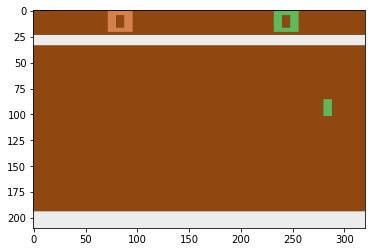

In [6]:
env = gym.make('PongDeterministic-v4')
state = env.reset()
for _ in range(1):
    action = env.action_space.sample()
    state, _, _, _ = env.step(action)
plt.imshow(cv2.resize(state, (320, 210), interpolation=cv2.INTER_NEAREST))

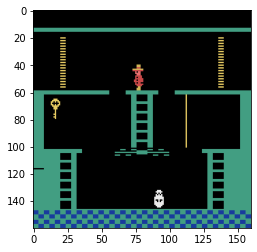

In [14]:
env = gym.make('MontezumaRevengeDeterministic-v4')
state = env.reset()
for _ in range(1):
    action = env.action_space.sample()
    state, _, _, _ = env.step(action)
plt.imshow(state[34:194, :, :])

In [19]:
def color_quantize(img, n_colors):
    bits = np.log2(n_colors)
    diff = 8 - bits # Assumes 2^8 = 256 original pixel depth
    K = 2**diff
    
    img = K * (img // K)
    return img

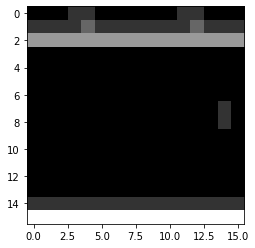

In [20]:
def downscale(img):
    # Crop and resize
#     img = img[34:194, :]

    # Convert to greyscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Shrink
    # https://github.com/uber-research/go-explore/blob/240056852514ffc39f62d32ae7590a39fd1814b9/robustified/goexplore_py/utils.py#L67
    img = cv2.resize(img, (16, 16), interpolation=cv2.INTER_AREA)
    
    # Reduce pixel depth
    img = color_quantize(img, 8)

    return img

cell_repr = downscale(state)
plt.imshow(cell_repr, cmap='gray')